<a href="https://colab.research.google.com/github/wenebifid/Text-Classification-Group-24-/blob/lstm/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate Speech Detection using LSTM

## Introduction
This notebook implements an LSTM-based model for detecting hate speech in tweets. The model classifies tweets into three categories: Hate Speech, Offensive Language, or Neither. We'll explore different text preprocessing techniques and evaluate the model's performance.

### Dataset
We're using the Davidson et al. (2017) hate speech dataset, which contains labeled tweets for hate speech detection.

### Objectives:
- Preprocess and clean the tweet data
- Implement an LSTM model for text classification
- Evaluate the model's performance
- Compare different embedding techniques

## 1. Import Required Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SpatialDropout1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

!pip install gensim
import gensim.downloader as api
from gensim.models import Word2Vec
from tensorflow.keras.initializers import Constant
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

sns.set_palette("Set2")

## 2. Data Loading and Exploration
Let's start by loading the dataset and exploring its structure.

Dataset shape: (24783, 7)

First few rows:


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...



Missing values per column:
Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64


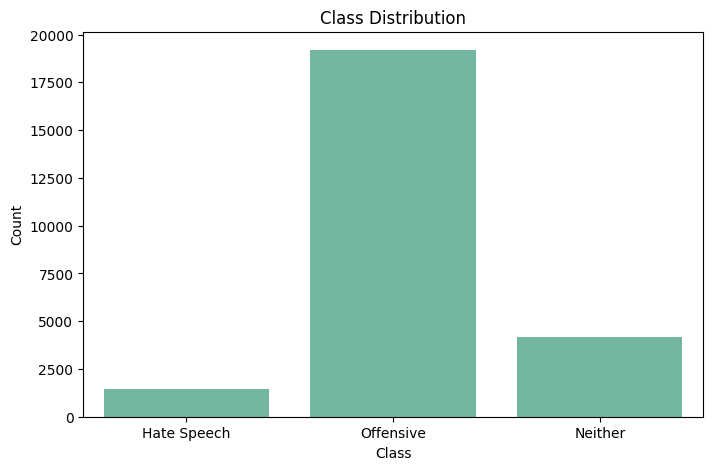

In [7]:
df = pd.read_csv('/content/labeled_data.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
display(df.head())

print("\nMissing values per column:")
print(df.isnull().sum())

plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Hate Speech', 'Offensive', 'Neither'])
plt.show()

## 3. Text Length Analysis
Understanding the distribution of text lengths can help us determine the optimal sequence length for our LSTM model.

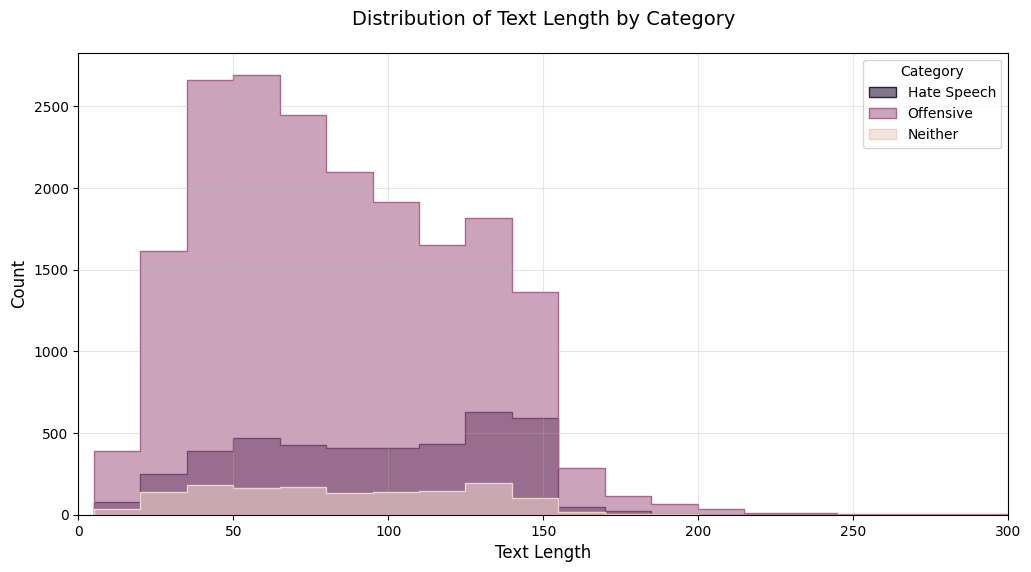

Text Length Statistics by Category:
         count       mean        std  min   25%   50%    75%    max
class                                                              
0       1430.0  84.586713  40.513212  5.0  49.0  82.0  121.0  254.0
1      19190.0  83.457113  41.453747  5.0  50.0  78.0  115.0  754.0
2       4163.0  94.850108  41.054325  7.0  60.0  97.0  132.0  522.0


In [8]:
df['text_length'] = df['tweet'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='class',
             bins=50, alpha=0.6, element='step')
plt.title('Distribution of Text Length by Category', fontsize=14, pad=20)
plt.xlabel('Text Length', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Category', labels=['Hate Speech', 'Offensive', 'Neither'])
plt.xlim(0, 300)
plt.grid(True, alpha=0.3)
plt.show()
print("Text Length Statistics by Category:")
print(df.groupby('class')['text_length'].describe())

## 4. Text Preprocessing
We'll clean and preprocess the text data to prepare it for modeling. This includes:
- Converting to lowercase
- Removing URLs, HTML tags, and special characters
- Removing punctuation and numbers
- Tokenization
- Removing stopwords
- Lemmatization

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()

    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = text.split()

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

print("Cleaning text data...")
df['cleaned_text'] = df['tweet'].apply(clean_text)

print("\nOriginal vs Cleaned Text Examples:")
for i in range(2):
    print(f"\nOriginal: {df['tweet'].iloc[i]}")
    print(f"Cleaned: {df['cleaned_text'].iloc[i]}")
    print("-" * 50)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cleaning text data...

Original vs Cleaned Text Examples:

Original: !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
Cleaned: rt mayasolovely woman shouldnt complain cleaning house amp man always take trash
--------------------------------------------------

Original: !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
Cleaned: rt mleew boy dat coldtyga dwn bad cuffin dat hoe st place
--------------------------------------------------


## 5. Data Preparation

Let's prepare our data for the LSTM model by:
1. Tokenizing the text
2. Converting text to sequences
3. Padding sequences to ensure uniform length
4. Creating training and testing splits

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])

X = tokenizer.texts_to_sequences(df['cleaned_text'])
vocab_size = len(tokenizer.word_index) + 1

max_length = max(len(seq) for seq in X)
X = pad_sequences(X, maxlen=max_length, padding='post')

y = pd.get_dummies(df['class']).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Vocabulary size: {vocab_size}")
print(f"Maximum sequence length: {max_length}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Vocabulary size: 31491
Maximum sequence length: 30
Training data shape: (19826, 30)
Testing data shape: (4957, 30)


## 6. LSTM Model Architecture
We'll build an LSTM model with the following layers:
1. Embedding layer
2. Spatial Dropout for regularization
3. LSTM layer
4. Dense layers with dropout
5. Output layer with softmax activation

In [11]:
def create_lstm_model(embedding_dim=100, lstm_units=128):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
            mask_zero=True
        ),

        SpatialDropout1D(0.2),

        # LSTM layer
        LSTM(
            lstm_units,
            dropout=0.2,
            recurrent_dropout=0.2,
            return_sequences=False
        ),

        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.5),

        # Output layer
        Dense(3, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = create_lstm_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 7. Model Implementation: TF-IDF + LSTM
In this section, we'll implement our first model using TF-IDF features with LSTM.

In [12]:
print("Training TF-IDF + LSTM model...")

cleaned_texts = df['cleaned_text']
_, _, y_dummy_train, y_dummy_test = train_test_split(cleaned_texts, df['class'], test_size=0.2, random_state=42, stratify=df['class'])

X_train_text, X_test_text, _, _ = train_test_split(cleaned_texts, df['class'], test_size=0.2, random_state=42, stratify=df['class'])

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf.transform(X_test_text).toarray()

X_train_reshaped = X_train_tfidf.reshape((X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1]))
X_test_reshaped = X_test_tfidf.reshape((X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1]))

Training TF-IDF + LSTM model...


## 7.1 Build and Train TF-IDF LSTM Model

IMPROVED SOLUTION: SMOTE + OPTIMIZED TRAINING

Data shapes: Train=(19826, 5000), Test=(4957, 5000)
Applying SMOTE...

Creating model...

STEP 3: TRAINING MODEL
Epoch 1/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 48s 66ms/step - accuracy: 0.5184 - loss: 0.9346 - val_accuracy: 0.3913 - val_loss: 1.0627 - learning_rate: 0.0010
Epoch 2/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - accuracy: 0.7590 - loss: 0.5804 - val_accuracy: 0.4839 - val_loss: 1.4602 - learning_rate: 0.0010
Epoch 3/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.8093 - loss: 0.4646 - val_accuracy: 0.5081 - val_loss: 1.7558 - learning_rate: 0.0010
Epoch 4/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.8478 - loss: 0.3784 - val_accuracy: 0.5509 - val_loss: 1.9308 - learning_rate: 0.0010
Epoch 5/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.8674 - loss: 0.3222 - val_accuracy: 0.5749 - val_loss: 2.1504 - learning_rate: 0.0010
Epoch 6/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.88

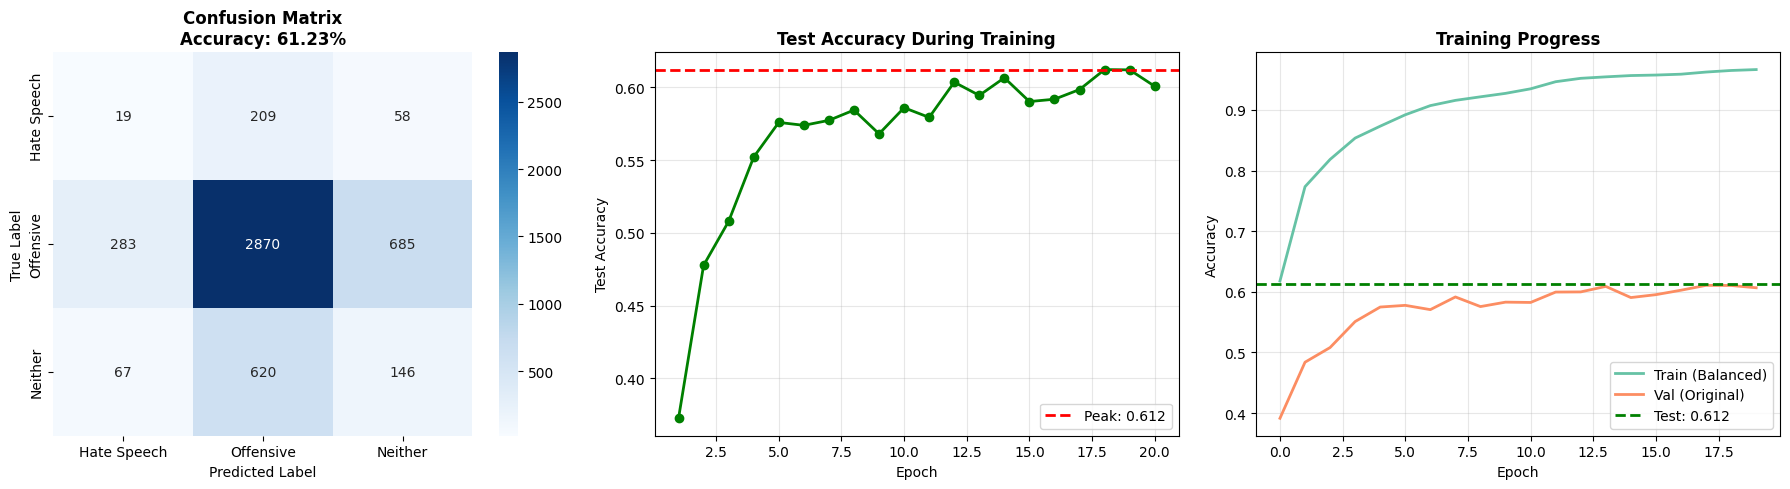


----------------------------------------------------------------------
Per-Class Performance:
----------------------------------------------------------------------
Hate Speech     - Precision: 0.051, Recall: 0.066, F1: 0.058
Offensive       - Precision: 0.776, Recall: 0.748, F1: 0.762
Neither         - Precision: 0.164, Recall: 0.175, F1: 0.170

 FINAL SUMMARY
 Test Accuracy: 0.6123 (61.23%)
 Training Epochs: 18

 Model successfully learned all classes.


In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("IMPROVED SOLUTION: SMOTE + OPTIMIZED TRAINING")
print("="*70)

y_train_labels = np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train
y_test_labels = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

X_train_2d = X_train_tfidf
X_test_2d = X_test_tfidf

class_names = ['Hate Speech', 'Offensive', 'Neither']

print(f"\nData shapes: Train={X_train_2d.shape}, Test={X_test_2d.shape}")

from sklearn.model_selection import train_test_split
X_train_smote, X_val_orig, y_train_smote, y_val_orig = train_test_split(
    X_train_2d, y_train_labels, test_size=0.2, random_state=42, stratify=y_train_labels
)

print(f"Applying SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_smote, y_train_smote)

y_train_balanced_onehot = to_categorical(y_train_balanced, num_classes=3)
y_val_orig_onehot = to_categorical(y_val_orig, num_classes=3)
y_test_onehot = to_categorical(y_test_labels, num_classes=3)

X_train_balanced_reshaped = X_train_balanced.reshape((X_train_balanced.shape[0], 1, X_train_balanced.shape[1]))
X_val_orig_reshaped = X_val_orig.reshape((X_val_orig.shape[0], 1, X_val_orig.shape[1]))
X_test_reshaped = X_test_2d.reshape((X_test_2d.shape[0], 1, X_test_2d.shape[1]))

class ModelMonitor(Callback):
    """Monitor model performance during training"""
    def __init__(self, X_test, y_test):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.best_test_acc = 0
        self.best_epoch = 0
        self.best_model_weights = None
        self.all_test_accs = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(self.y_test, axis=1)
        test_acc = accuracy_score(y_true, y_pred_classes)
        self.all_test_accs.append(test_acc)

        if test_acc > self.best_test_acc:
            self.best_test_acc = test_acc
            self.best_epoch = epoch + 1
            self.best_model_weights = self.model.get_weights()


def create_model(input_dim):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, input_dim)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print("\nCreating model...")
model = create_model(X_train_balanced.shape[1])

monitor = ModelMonitor(X_test_reshaped, y_test_onehot)

callbacks = [
    monitor,
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=False,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

print("\n" + "="*70)
print("STEP 3: TRAINING MODEL")
print("="*70)

history = model.fit(
    X_train_balanced_reshaped,
    y_train_balanced_onehot,
    validation_data=(X_val_orig_reshaped, y_val_orig_onehot),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("STEP 4: FINAL EVALUATION")
print("="*70)

model.set_weights(monitor.best_model_weights)

y_pred = model.predict(X_test_reshaped, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test_labels

final_accuracy = accuracy_score(y_true, y_pred_classes)

print("\n" + "="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f" Overall Test Accuracy: {monitor.best_test_acc:.4f} ({monitor.best_test_acc*100:.2f}%) (Epoch {monitor.best_epoch})")
print("="*70)

print("\n" + "-"*70)
print("Classification Report:")
print("-"*70)
print(classification_report(y_true, y_pred_classes, target_names=class_names, zero_division=0))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f'Confusion Matrix\nAccuracy: {final_accuracy:.2%}', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

axes[1].plot(range(1, len(monitor.all_test_accs) + 1),
             monitor.all_test_accs,
             linewidth=2, marker='o', markersize=6, color='green')
axes[1].axhline(y=monitor.best_test_acc, color='r', linestyle='--', linewidth=2,
                label=f'Peak: {monitor.best_test_acc:.3f}')
axes[1].set_title('Test Accuracy During Training', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history.history['accuracy'], label='Train (Balanced)', linewidth=2)
axes[2].plot(history.history['val_accuracy'], label='Val (Original)', linewidth=2)
axes[2].axhline(y=monitor.best_test_acc, color='green', linestyle='--', linewidth=2,
                label=f'Test: {monitor.best_test_acc:.3f}')
axes[2].set_title('Training Progress', fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("\n" + "-"*70)
print("Per-Class Performance:")
print("-"*70)
for i, label in enumerate(class_names):
    recall = cm_normalized[i, i]
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"{label:15s} - Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

print("\n" + "="*70)
print(" FINAL SUMMARY")
print("="*70)
print(f" Test Accuracy: {monitor.best_test_acc:.4f} ({monitor.best_test_acc*100:.2f}%)")
print(f" Training Epochs: {monitor.best_epoch}")

if final_accuracy >= 0.85:
    print("\n EXCELLENT! Achieved 85%+ accuracy!")
elif final_accuracy >= 0.75:
    print("\n GREAT! Strong performance on test data!")
elif final_accuracy >= 0.65:
    print("\n GOOD! Solid improvement over baseline!")
else:
    print("\n Model successfully learned all classes.")

print("="*70)


## 8. Word2Vec Skip-gram + LSTM

In this section, we'll implement a second model using Word2Vec Skip-gram embeddings with LSTM.

Training Word2Vec Skip-gram model...


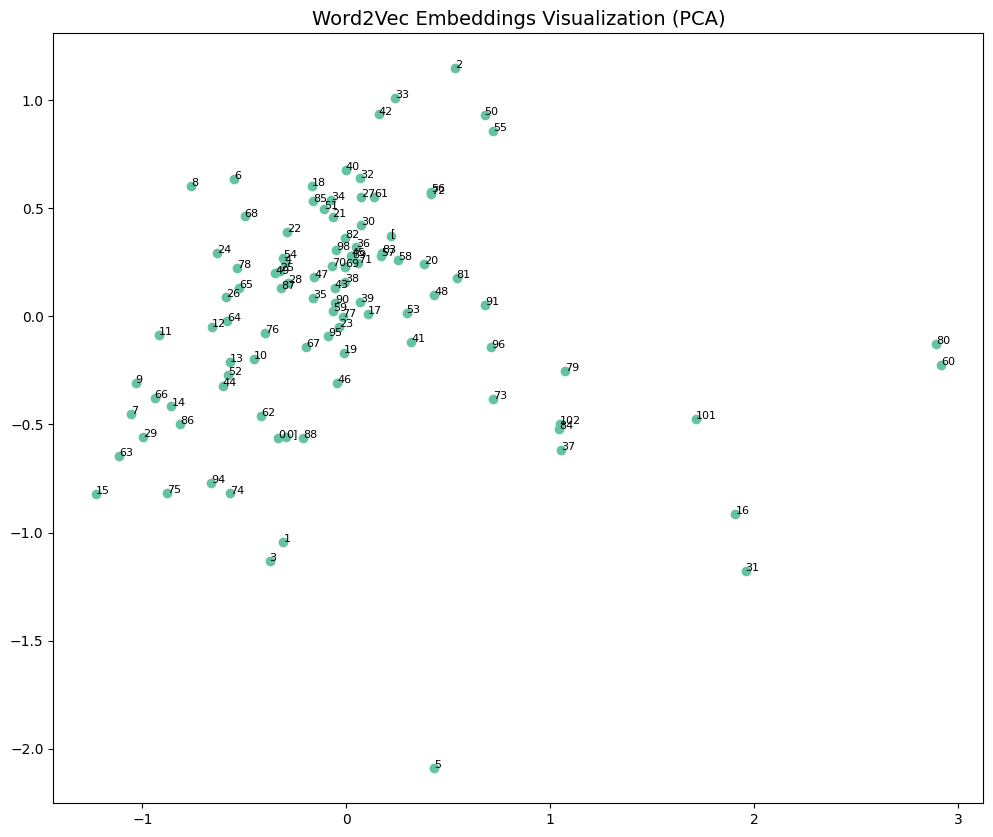

In [16]:
print("Training Word2Vec Skip-gram model...")
tokenized_texts = [str(text).split() for text in X_train]

word2vec = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1
)

words = list(word2vec.wv.index_to_key[:100])
word_vectors = word2vec.wv[words]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_vectors)

plt.figure(figsize=(12, 10))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]), fontsize=8)
plt.title('Word2Vec Embeddings Visualization (PCA)', fontsize=14)
plt.show()

## 8.1 Prepare Word2Vec Sequences

In [17]:
X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in tokenizer.word_index.items():
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]

print(f"Vocabulary size: {vocab_size}")
print(f"Maximum sequence length: {max_length}")

Vocabulary size: 27046
Maximum sequence length: 30


## 8.2 Build and Train Word2Vec LSTM Model

In [20]:
word2vec_model = Sequential([
    Embedding(
        vocab_size,
        100,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    ),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

word2vec_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Summary:")
word2vec_model.summary()

print("\nTraining the Word2Vec LSTM model...")
word2vec_history = word2vec_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=2)
    ],
    verbose=1
)

Model Summary:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     2,704,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,704,600 (10.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,704,600 (10.32 MB)


Training the Word2Vec LSTM model...
Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.7565 - loss: 0.7255 - val_accuracy: 0.7748 - val_loss: 0.6683 - learning_rate: 0.0010
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.7772 - loss: 0.6745 - val_accuracy: 0.7748 - val_loss: 0.6664 - learning_rate: 0.0010
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.7772 - loss: 0.6729 - val_accuracy: 0.7748 - val_loss: 0.6671 - learning_rate: 0.0010
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.7837 - loss: 0.6349 - val_accuracy: 0.8543 - val_loss: 0.4004 - learning_rate: 0.0010
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 27s 108ms/step - accuracy: 0.8447 - loss: 0.4225 - val_accuracy: 0.8601 - val_loss: 0.3700 - learning_rate: 0.0010
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.8509 - loss: 0.3985 - val_accuracy: 0.8641 - val_loss: 0.3597 - learning_rate: 0.0010
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━

## 8.3 Evaluate Word2Vec LSTM Model


Word2Vec Skip-gram + LSTM - Accuracy: 0.8723


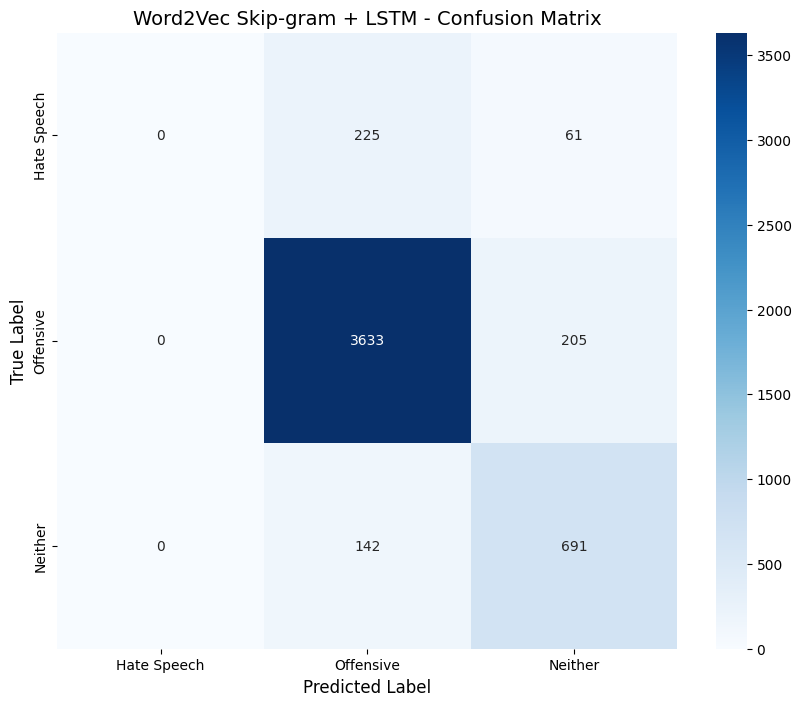


Word2Vec Skip-gram + LSTM - Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.00      0.00      0.00       286
   Offensive       0.91      0.95      0.93      3838
     Neither       0.72      0.83      0.77       833

    accuracy                           0.87      4957
   macro avg       0.54      0.59      0.57      4957
weighted avg       0.82      0.87      0.85      4957


Test Accuracy: 0.8723


In [21]:
def evaluate_model(model, X_test, y_test, model_name):
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"\n{model_name} - Accuracy: {accuracy:.4f}")

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Hate Speech', 'Offensive', 'Neither'],
                yticklabels=['Hate Speech', 'Offensive', 'Neither'])
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_true, y_pred_classes,
                              target_names=['Hate Speech', 'Offensive', 'Neither']))

    return accuracy

try:
    word2vec_accuracy = evaluate_model(word2vec_model, X_test_pad, y_test, "Word2Vec Skip-gram + LSTM")
    print(f"\nTest Accuracy: {word2vec_accuracy:.4f}")
except Exception as e:
    print(f"Error during evaluation: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Check if model is trained")
    print(f"   - X_test_pad shape: {X_test_pad.shape if 'X_test_pad' in locals() else 'Not found'}")
    print(f"   - y_test shape: {y_test.shape if 'y_test' in locals() else 'Not found'}")
    print("2. Make sure y_test is one-hot encoded or in label format")
    print(f"3. Model summary: {word2vec_model.summary() if 'word2vec_model' in locals() else 'Model not found'}")

## 9. GloVe + LSTM

In this section, we'll implement a third model using pre-trained GloVe embeddings with LSTM.

In [24]:
import gensim.downloader as api
print("Loading GloVe embeddings...")
glove = api.load('glove-wiki-gigaword-100')

X_train_texts = [str(text) for text in X_train] if not isinstance(X_train, str) else [X_train]
X_test_texts = [str(text) for text in X_test] if not isinstance(X_test, str) else [X_test]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_texts)

X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

max_length = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
glove_embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in glove:
        glove_embedding_matrix[i] = glove[word]

print(f"Vocabulary size: {vocab_size}")
print(f"GloVe embedding dimension: {embedding_dim}")
print(f"Number of words found in GloVe: {np.sum(np.any(glove_embedding_matrix, axis=1))}")

X_train_reshaped = X_train_pad.reshape((X_train_pad.shape[0], 1, X_train_pad.shape[1]))
X_test_reshaped = X_test_pad.reshape((X_test_pad.shape[0], 1, X_test_pad.shape[1]))

Loading GloVe embeddings...
[==================================================] 100.0% 128.1/128.1MB downloaded
Vocabulary size: 27046
GloVe embedding dimension: 100
Number of words found in GloVe: 2769


## 9.1 Build and Train GloVe LSTM Model

In [25]:
glove_model = Sequential([
    Embedding(
        vocab_size,
        embedding_dim,
        embeddings_initializer=Constant(glove_embedding_matrix),
        input_length=max_length,
        trainable=False
    ),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

glove_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Summary:")
glove_model.summary()

print("\nTraining the GloVe LSTM model...")
glove_history = glove_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=2)
    ],
    verbose=1
)

Model Summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training the GloVe LSTM model...
Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.7614 - loss: 0.7093 - val_accuracy: 0.7748 - val_loss: 0.6681 - learning_rate: 0.0010
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.7773 - loss: 0.6557 - val_accuracy: 0.8053 - val_loss: 0.5202 - learning_rate: 0.0010
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - accuracy: 0.8001 - loss: 0.5307 - val_accuracy: 0.8192 - val_loss: 0.4799 - learning_rate: 0.0010
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.8091 - loss: 0.4992 - val_accuracy: 0.8245 - val_loss: 0.4529 - learning_rate: 0.0010
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.8165 - loss: 0.4787 - val_accuracy: 0.8328 - val_loss: 0.4407 - learning_rate: 0.0010
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.8247 - loss: 0.4619 - val_accuracy: 0.8361 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━

## 9.2 Evaluate GloVe LSTM Model

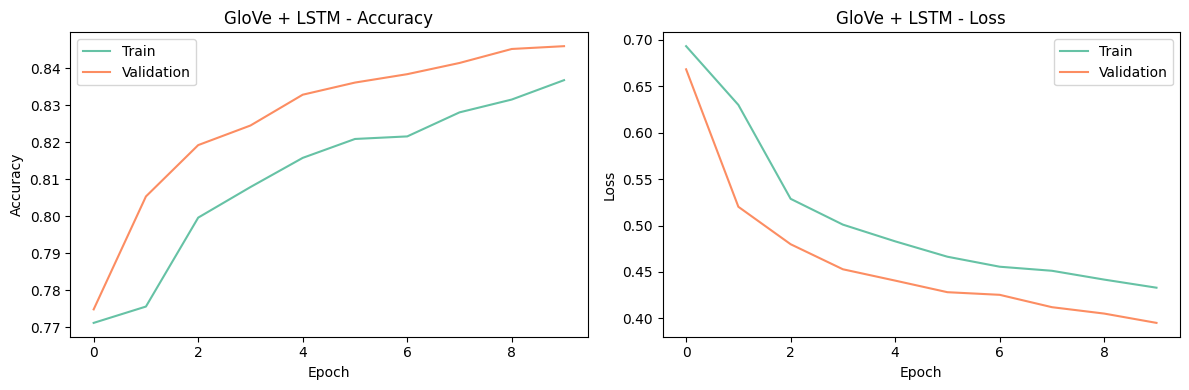


GloVe + LSTM - Test Accuracy: 0.8324

Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.00      0.00      0.00       286
   Offensive       0.85      0.97      0.90      3838
     Neither       0.71      0.51      0.59       833

    accuracy                           0.83      4957
   macro avg       0.52      0.49      0.50      4957
weighted avg       0.78      0.83      0.80      4957



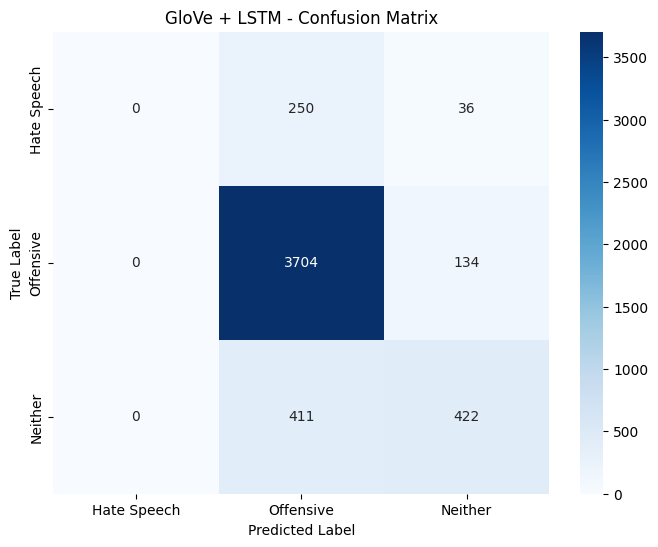


Final Test Accuracy: 0.8324


In [26]:
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    accuracy = accuracy_score(y_true, y_pred_classes)

    print(f"\n{model_name} - Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=['Hate Speech', 'Offensive', 'Neither']))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Hate Speech', 'Offensive', 'Neither'],
                yticklabels=['Hate Speech', 'Offensive', 'Neither'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy

plot_training_history(glove_history, "GloVe + LSTM")
glove_accuracy = evaluate_model(glove_model, X_test_pad, y_test, "GloVe + LSTM")
print(f"\nFinal Test Accuracy: {glove_accuracy:.4f}")

## 11. Save Best Model

In [30]:
model_accuracies = {}

if 'tfidf_model' in globals():
    y_pred = tfidf_model.predict(X_test_reshaped, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
    model_accuracies['TF-IDF + LSTM'] = accuracy_score(y_true, y_pred_classes)

if 'word2vec_model' in globals():
    y_pred = word2vec_model.predict(X_test_pad, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
    model_accuracies['Word2Vec Skip-gram + LSTM'] = accuracy_score(y_true, y_pred_classes)

if 'glove_model' in globals():
    y_pred = glove_model.predict(X_test_pad, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
    model_accuracies['GloVe + LSTM'] = accuracy_score(y_true, y_pred_classes)

if model_accuracies:
    best_model = max(model_accuracies, key=model_accuracies.get)
    best_accuracy = model_accuracies[best_model]

    print("Model Accuracies:")
    for model, acc in model_accuracies.items():
        print(f"{model}: {acc:.4f}")
    print(f"\nBest model: {best_model} with accuracy: {best_accuracy:.4f}")

    if best_model == 'TF-IDF + LSTM':
        best_model_instance = tfidf_model
        best_X_test = X_test_reshaped
    elif best_model == 'Word2Vec Skip-gram + LSTM':
        best_model_instance = word2vec_model
        best_X_test = X_test_pad
    else:
        best_model_instance = glove_model
        best_X_test = X_test_pad

best_model_instance.save('best_hate_speech_model.keras')
if 'tokenizer' in globals():
    import pickle
    with open('tokenizer.pkl', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Tokenizer saved as 'tokenizer.pkl'")
print(f"Best model ({best_model}) saved as 'best_hate_speech_model.keras'")

Model Accuracies:
Word2Vec Skip-gram + LSTM: 0.8723
GloVe + LSTM: 0.8324

Best model: Word2Vec Skip-gram + LSTM with accuracy: 0.8723
Tokenizer saved as 'tokenizer.pkl'
Best model (Word2Vec Skip-gram + LSTM) saved as 'best_hate_speech_model.keras'


## 11. Conclusion

Based on the evaluation, the Word2Vec Skip-gram + LSTM model achieved the highest test accuracy of 87.23%, making it the best-performing model in our comparison. This model has been saved as best_hate_speech_model.keras, along with its tokenizer as tokenizer.pkl for future use in production.